In [2]:
from matplotlib.pylab import *
from matplotlib.patches import Rectangle
from matplotlib.collections import PatchCollection
from matplotlib.lines import Line2D
π = pi

In [3]:
style.use(['dark_background', 'bmh'])
%matplotlib notebook

Car-trailer diagram (inverted image `res/car-trainer-k.png` available as well):
![car-trailer](res/car-trailer-w.png)

Car-trailer equation:
\begin{align}
\dot x &= s \cos \theta_0 \\
\dot y &= s \sin \theta_0 \\
\dot \theta_0 &= \frac{s}{L} \tan \phi \\
\dot \theta_1 &= \frac{s}{d_1} \sin(\theta_1 - \theta_0)
\end{align}
where $s$: signed speed, $\phi$: negative steering angle,

In [4]:
class Truck:
    def __init__(self, display=False):

        self.W = 1  # car and trailer width, for drawing only
        self.L = 1 * self.W  # car length
        self.d = 4 * self.L  # d_1
        self.s = -0.1  # speed
        self.display = display
        
        self.box = [0, 40, -10, 10]
        if self.display:
            self.f = figure(figsize=(10, 5), num='The truck backer-upper', facecolor='none')
            self.ax = self.f.add_axes([0.01, 0.01, 0.98, 0.98], facecolor='black')
            self.patches = list()
            
            self.ax.axis('equal')
            b = self.box
            self.ax.axis([b[0] - 1, b[1], b[2], b[3]])
            self.ax.set_xticks([]); self.ax.set_yticks([])
            self.ax.axhline(); self.ax.axvline()

        self.reset()

    def randomize_between(self, x_min, x_max, y_min, y_max, θ0_min, θ0_max, θ1_min, θ1_max):
        #convert to radians
        θ0_min = θ0_min * π/ 180
        θ0_max = θ0_max * π/ 180
        θ1_min = θ1_min * π/ 180
        θ1_max = θ1_max * π/ 180

        #randomize values between min and max
        self.θ0 = np.random.uniform(θ0_min, θ0_max) #(random() - (θ0_max + θ0_min)/2) * (θ0_max - θ0_min)
        self.θ1 = np.random.uniform(θ1_min, θ1_max) + self.θ0 #(random() - (θ1_max + θ1_min)/2) * (θ1_max - θ1_min)
        self.x = np.random.uniform(x_min, x_max) #(random() - (x_max + x_min)/2) * (x_max - x_min)
        self.y = np.random.uniform(y_min, y_max) #(random() - (y_max + y_min)/2) * (y_max - y_min)
        
        # If poorly initialise, then re-initialise
        if not self.valid():
            self.randomize_between(x_min, x_max, y_min, y_max, θ0_min, θ0_max, θ1_min, θ1_max)
        
        # Draw, if display is True
        if self.display: self.draw()

    
    def reset(self, ϕ=0):
        self.ϕ = ϕ  # car initial steering angle

        self.θ0 = random() * 2 * π  # 0 <= ϑ₀ < 2π
        self.θ1 = (random() - 0.5) * π / 2 + self.θ0  # -π/4 <= ϑ₁ - ϑ₀ < π/4
        self.x = (random() * .75 + 0.25) * self.box[1]
        self.y = (random() - 0.5) * (self.box[3] - self.box[2])
    
        # self.θ0 = deg2rad(30)  # car initial direction
        # self.θ1 = deg2rad(-30)  # trailer initial direction
        # self.x, self.y = 20, -5  # initial car coordinates
        
        self.θ0 = random() * 2 * π  # 0 <= ϑ₀ < 2π
        self.θ1 = (random() - 0.5) * π / 2 + self.θ0  # -π/4 <= ϑ₁ - ϑ₀ < π/4
        self.x = (random() * .75 + 0.25) * self.box[1]
        self.y = (random() - 0.5) * (self.box[3] - self.box[2])
        
        # If poorly initialise, then re-initialise
        if not self.valid():
            self.reset(ϕ)
        
        # Draw, if display is True
        if self.display: self.draw()
    
    def step(self, ϕ=0, dt=1):
        
        # Check for illegal conditions
        if self.is_jackknifed():
            # print('The truck is jackknifed!')
            return (self.x, self.y, self.θ0, *self._traler_xy(), self.θ1)
        
        if self.is_offscreen():
            # print('The car or trailer is off screen')
            return (self.x, self.y, self.θ0, *self._traler_xy(), self.θ1)
        
        self.ϕ = ϕ
        x, y, W, L, d, s, θ0, θ1, ϕ = self._get_atributes()
        
        # Perform state update
        self.x += s * cos(θ0) * dt
        self.y += s * sin(θ0) * dt
        self.θ0 += s / L * tan(ϕ) * dt
        self.θ1 += s / d * sin(θ0 - θ1) * dt
        
        return (self.x, self.y, self.θ0, *self._traler_xy(), self.θ1)
    
    def state(self):
        return (self.x, self.y, self.θ0, *self._traler_xy(), self.θ1)
    
    def _get_atributes(self):
        return (
            self.x, self.y, self.W, self.L, self.d, self.s,
            self.θ0, self.θ1, self.ϕ
        )
    
    def _traler_xy(self):
        x, y, W, L, d, s, θ0, θ1, ϕ = self._get_atributes()
        return x - d * cos(θ1), y - d * sin(θ1)
        
    def is_jackknifed(self):
        x, y, W, L, d, s, θ0, θ1, ϕ = self._get_atributes()
        return abs(θ0 - θ1) * 180 / π > 90
    
    def is_offscreen(self):
        x, y, W, L, d, s, θ0, θ1, ϕ = self._get_atributes()
        
        x1, y1 = x + 1.5 * L * cos(θ0), y + 1.5 * L * sin(θ0)
        x2, y2 = self._traler_xy()
        
        b = self.box
        return not (
            b[0] <= x1 <= b[1] and b[2] <= y1 <= b[3] and
            b[0] <= x2 <= b[1] and b[2] <= y2 <= b[3]
        )
    
    def is_atdock(self):
        x,y = self._traler_xy()
        return (x<0.1) and (abs(y)<0.1)

    def can_continue(self):
        return not self.is_atdock() or  not self.is_offscreen()
        
    def valid(self):
        return not self.is_jackknifed() and not self.is_offscreen()
        
    def draw(self):
        if not self.display: return
        if self.patches: self.clear()
        self._draw_car()
        self._draw_trailer()
        self.f.canvas.draw()
            
    def clear(self):
        for p in self.patches:
            p.remove()
        self.patches = list()
        
    def _draw_car(self):
        x, y, W, L, d, s, θ0, θ1, ϕ = self._get_atributes()
        ax = self.ax
        
        x1, y1 = x + L / 2 * cos(θ0), y + L / 2 * sin(θ0)
        bar = Line2D((x, x1), (y, y1), lw=5, color='C2', alpha=0.8)
        ax.add_line(bar)

        car = Rectangle(
            (x1, y1 - W / 2), L, W, 0, color='C2', alpha=0.8, transform=
            matplotlib.transforms.Affine2D().rotate_deg_around(x1, y1, θ0 * 180 / π) +
            ax.transData
        )
        ax.add_patch(car)

        x2, y2 = x1 + L / 2 ** 0.5 * cos(θ0 + π / 4), y1 + L / 2 ** 0.5 * sin(θ0 + π / 4)
        left_wheel = Line2D(
            (x2 - L / 4 * cos(θ0 + ϕ), x2 + L / 4 * cos(θ0 + ϕ)),
            (y2 - L / 4 * sin(θ0 + ϕ), y2 + L / 4 * sin(θ0 + ϕ)),
            lw=3, color='C5', alpha=1)
        ax.add_line(left_wheel)

        x3, y3 = x1 + L / 2 ** 0.5 * cos(π / 4 - θ0), y1 - L / 2 ** 0.5 * sin(π / 4 - θ0)
        right_wheel = Line2D(
            (x3 - L / 4 * cos(θ0 + ϕ), x3 + L / 4 * cos(θ0 + ϕ)),
            (y3 - L / 4 * sin(θ0 + ϕ), y3 + L / 4 * sin(θ0 + ϕ)),
            lw=3, color='C5', alpha=1)
        ax.add_line(right_wheel)
        
        self.patches += [car, bar, left_wheel, right_wheel]
        
    def _draw_trailer(self):
        x, y, W, L, d, s, θ0, θ1, ϕ = self._get_atributes()
        ax = self.ax
            
        x, y = x - d * cos(θ1), y - d * sin(θ1) - W / 2
        trailer = Rectangle(
            (x, y), d, W, 0, color='C0', alpha=0.8, transform=
            matplotlib.transforms.Affine2D().rotate_deg_around(x, y + W/2, θ1 * 180 / π) +
            ax.transData
        )
        ax.add_patch(trailer)
        
        self.patches += [trailer]

<IPython.core.display.Javascript object>


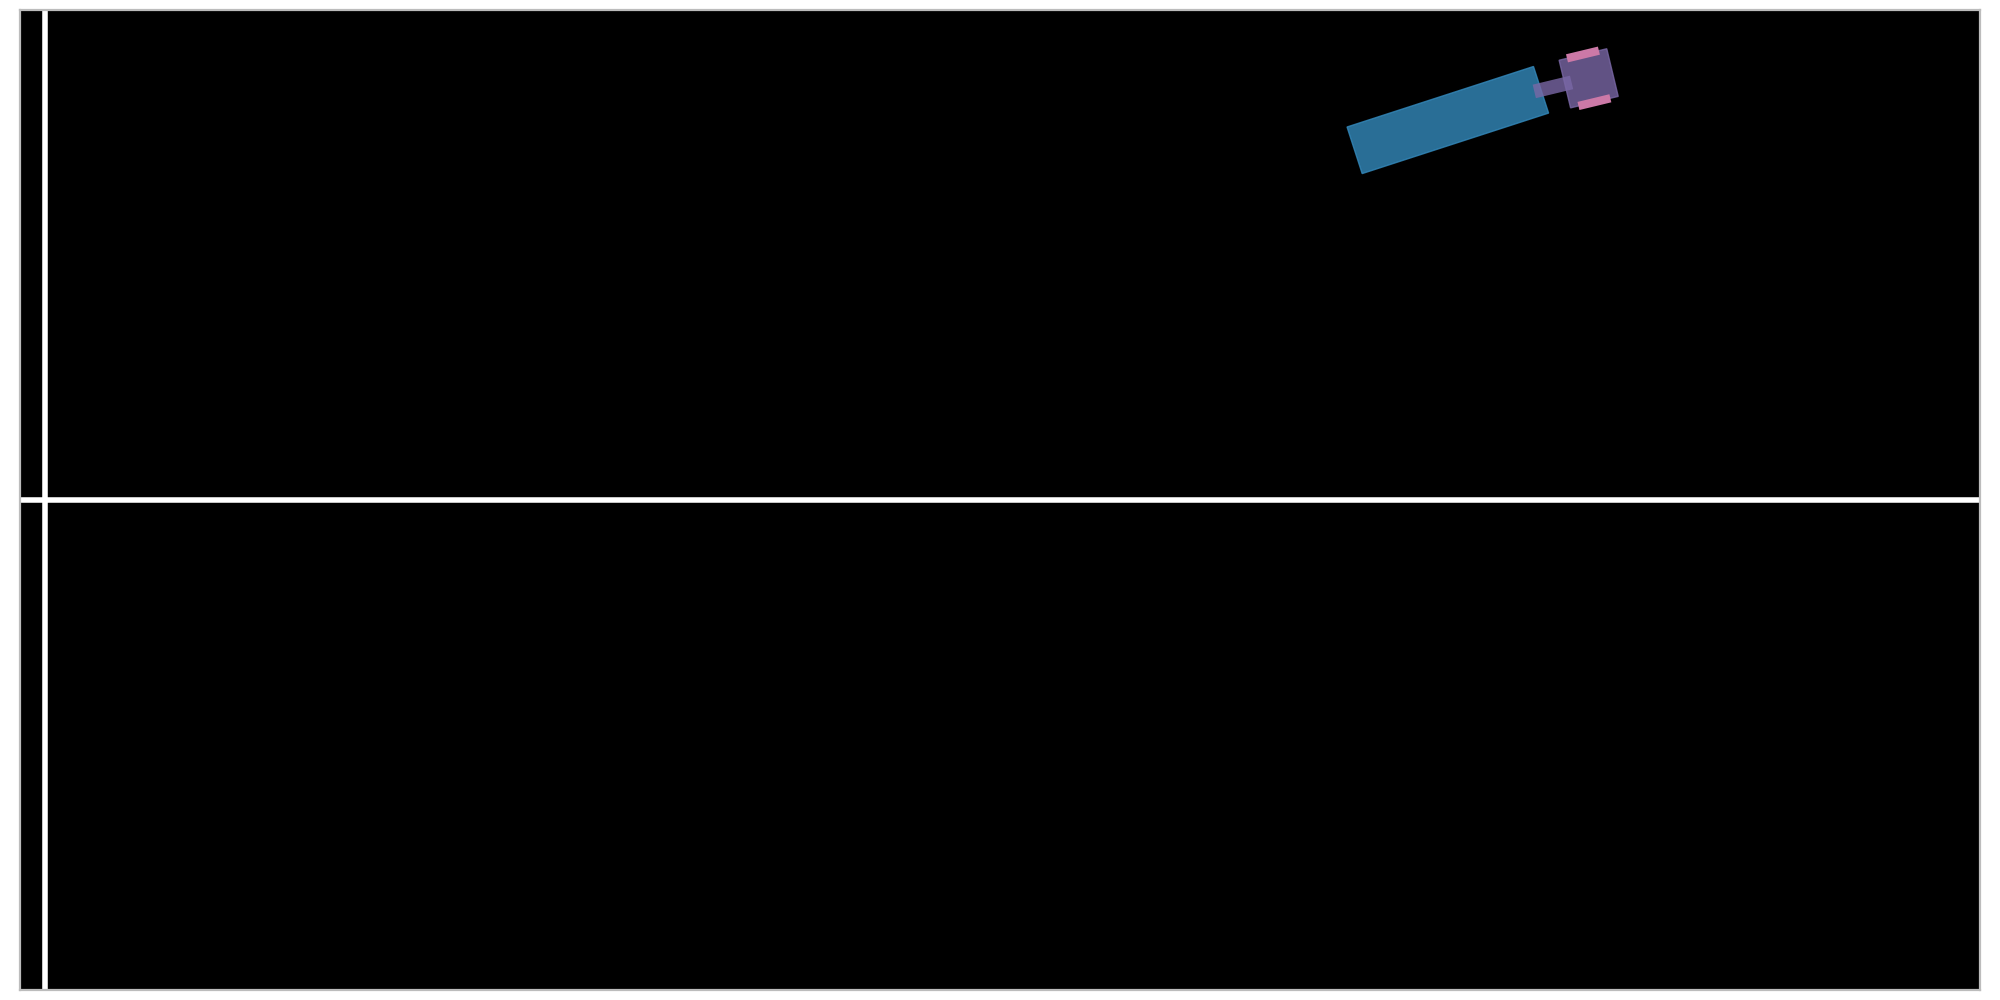

/var/folders/cb/80tm85vn2kq1w8lvgbf4v6dr0000gn/T/ipykernel_7544/2638417292.py:150: MatplotlibDeprecationWarning: Passing the angle parameter of __init__() positionally is deprecated since Matplotlib 3.6; the parameter will become keyword-only two minor releases later.
  car = Rectangle(
/var/folders/cb/80tm85vn2kq1w8lvgbf4v6dr0000gn/T/ipykernel_7544/2638417292.py:178: MatplotlibDeprecationWarning: Passing the angle parameter of __init__() positionally is deprecated since Matplotlib 3.6; the parameter will become keyword-only two minor releases later.
  trailer = Rectangle(


In [5]:
truck = Truck(display=True)

In [6]:
ϕ = deg2rad(-35)  # positive left, negative right
truck.step(ϕ)
truck.draw()
print(truck.state())

(18.087052743792317, -4.768724146807056, 0.17033379276927466, 14.08744937653763, -4.8250526888171805, 0.014082600973998759)


/var/folders/cb/80tm85vn2kq1w8lvgbf4v6dr0000gn/T/ipykernel_7544/2638417292.py:150: MatplotlibDeprecationWarning: Passing the angle parameter of __init__() positionally is deprecated since Matplotlib 3.6; the parameter will become keyword-only two minor releases later.
  car = Rectangle(
/var/folders/cb/80tm85vn2kq1w8lvgbf4v6dr0000gn/T/ipykernel_7544/2638417292.py:178: MatplotlibDeprecationWarning: Passing the angle parameter of __init__() positionally is deprecated since Matplotlib 3.6; the parameter will become keyword-only two minor releases later.
  trailer = Rectangle(


In [7]:
truck.reset()

/var/folders/cb/80tm85vn2kq1w8lvgbf4v6dr0000gn/T/ipykernel_7544/2638417292.py:150: MatplotlibDeprecationWarning: Passing the angle parameter of __init__() positionally is deprecated since Matplotlib 3.6; the parameter will become keyword-only two minor releases later.
  car = Rectangle(
/var/folders/cb/80tm85vn2kq1w8lvgbf4v6dr0000gn/T/ipykernel_7544/2638417292.py:178: MatplotlibDeprecationWarning: Passing the angle parameter of __init__() positionally is deprecated since Matplotlib 3.6; the parameter will become keyword-only two minor releases later.
  trailer = Rectangle(


In [8]:
import torch
import torch.nn as nn
from torch.optim import SGD
from tqdm import tqdm

In [9]:
# Build expert data set

episodes = 10
inputs = list()
outputs = list()
truck = Truck(); episodes = 10_000  # uncooment for creating the data set

for episode in tqdm(range(episodes)):
    
    truck.reset()
    
    while truck.valid():
        initial_state = truck.state()
        ϕ = (random() - 0.5) * π / 2
        inputs.append((ϕ, *initial_state))
        outputs.append(truck.step(ϕ))
        truck.draw()

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:15<00:00, 665.04it/s]


In [10]:
len(inputs), len(outputs)

(597271, 597271)

In [11]:
state_size = 6
steering_size = 1
hidden_units_e = 45

emulator = nn.Sequential(
    nn.Linear(steering_size + state_size, hidden_units_e),
    nn.ReLU(),
    nn.Linear(hidden_units_e, state_size)
)

optimiser_e = SGD(emulator.parameters(), lr=0.005)
criterion = nn.MSELoss()

In [12]:
tensor_inputs = torch.Tensor(inputs)
tensor_outputs = torch.Tensor(outputs)

In [13]:
mean = tensor_inputs.mean(0)
std = tensor_inputs.std(0)
tensor_inputs = (tensor_inputs - mean) / std
tensor_outputs = (tensor_outputs - mean[1:]) / std[1:]

In [14]:
# Split the data into 80:20 for test:train.
test_size = int(len(tensor_inputs) * 0.8)
print(len(tensor_inputs), test_size)

train_inputs = tensor_inputs[:test_size]
train_outputs = tensor_outputs[:test_size]
test_inputs = tensor_inputs[test_size:]
test_outputs = tensor_outputs[test_size:]

597271 477816


In [15]:
len(train_inputs)

477816

In [16]:
# Emulator training
cnt = 0
for i in torch.randperm(len(train_inputs)):
    ϕ_state = train_inputs[i]
    next_state_prediction = emulator(ϕ_state)
    
    next_state = train_outputs[i]
    loss = criterion(next_state_prediction, next_state)
    
    optimiser_e.zero_grad()
    loss.backward()
    optimiser_e.step()
    
    if cnt == 0 or (cnt + 1) % 1000 == 0:
        print(f'{cnt + 1:4d} / {len(train_inputs)}, {loss.item():.10f}')
    cnt += 1

   1 / 477816, 1.4296797514
1000 / 477816, 0.0529406033
2000 / 477816, 0.0613102801
3000 / 477816, 0.0493180044
4000 / 477816, 0.0600546189
5000 / 477816, 0.0320107974
6000 / 477816, 0.0178903956
7000 / 477816, 0.0161335748
8000 / 477816, 0.0248042550
9000 / 477816, 0.0044269883
10000 / 477816, 0.0139293363
11000 / 477816, 0.0106585240
12000 / 477816, 0.0087303501
13000 / 477816, 0.0035601854
14000 / 477816, 0.0021611080
15000 / 477816, 0.0096033076
16000 / 477816, 0.0050681890
17000 / 477816, 0.0077573727
18000 / 477816, 0.0031866368
19000 / 477816, 0.0023394038
20000 / 477816, 0.0014586974
21000 / 477816, 0.0184018314
22000 / 477816, 0.0049521085
23000 / 477816, 0.0020292674
24000 / 477816, 0.0017871925
25000 / 477816, 0.0051242509
26000 / 477816, 0.0043260474
27000 / 477816, 0.0035964120
28000 / 477816, 0.0015951894
29000 / 477816, 0.0013603382
30000 / 477816, 0.0017841515
31000 / 477816, 0.0002865665
32000 / 477816, 0.0032981101
33000 / 477816, 0.0006025733
34000 / 477816, 0.004174

277000 / 477816, 0.0003494970
278000 / 477816, 0.0003107690
279000 / 477816, 0.0003262894
280000 / 477816, 0.0000973577
281000 / 477816, 0.0005725205
282000 / 477816, 0.0001174069
283000 / 477816, 0.0035886429
284000 / 477816, 0.0000269005
285000 / 477816, 0.0000766496
286000 / 477816, 0.0003708808
287000 / 477816, 0.0002014214
288000 / 477816, 0.0002231701
289000 / 477816, 0.0001861641
290000 / 477816, 0.0002179292
291000 / 477816, 0.0000978123
292000 / 477816, 0.0000209625
293000 / 477816, 0.0002607302
294000 / 477816, 0.0001008913
295000 / 477816, 0.0001661362
296000 / 477816, 0.0001999292
297000 / 477816, 0.0001401791
298000 / 477816, 0.0001079139
299000 / 477816, 0.0003482796
300000 / 477816, 0.0001762202
301000 / 477816, 0.0000660099
302000 / 477816, 0.0000787078
303000 / 477816, 0.0003619413
304000 / 477816, 0.0000926876
305000 / 477816, 0.0000455601
306000 / 477816, 0.0001500183
307000 / 477816, 0.0001016912
308000 / 477816, 0.0013840101
309000 / 477816, 0.0002662288
310000 / 4

In [17]:
# Test
total_loss = 0
with torch.no_grad():
    for idx, ϕ_state in enumerate(test_inputs):
        next_state_prediction = emulator(ϕ_state)

        next_state = test_outputs[idx]
        total_loss += criterion(next_state_prediction, next_state).item()

ave_test_loss = total_loss/test_size
print(f'Test loss: {ave_test_loss:.10f}')

Test loss: 0.0000353756


In [ ]:

# Here you need to insert the code for training the controller
# by using the emulator for backpropagation
import numpy as np
import torch.optim as optim
from torch.utils.tensorboard import SummaryWriter

class c_model(torch.nn.Module):
    def __init__(self):
        super(c_model, self).__init__()

        self.layers = nn.Sequential(
                        nn.Linear(state_size, 45),
                        nn.ReLU(),
                        nn.Linear(45, 600),
                        nn.ReLU(),
                        nn.Linear(600, 45),
                        nn.ReLU(),
                        nn.Linear(45, 1),
                        nn.Tanh(),
                    )

    def forward(self, x):

        n_steer = self.layers(x)
        
        return torch.mul(n_steer, (π/2))

Controller = c_model()

#Change this to start at a different lesson
starting_lesson = 1

#change this to load saved weights for the started lesson
load_weights = False
load_lesson = 5


#initialize optimizer
optimiser_c = SGD(Controller.parameters(), lr=1e-2)
criterion = nn.MSELoss()

if load_weights:
    print("Loading Weights for Lesson: "+ str(load_lesson))
    checkpoint = torch.load("lesson_" + str(load_lesson) + "_checkpoint")
    Controller.load_state_dict(checkpoint['model_state_dict'])
    optimiser_c.load_state_dict(checkpoint['optimizer_state_dict'])

#log for tensorboard
writer = SummaryWriter("Controller_Train_Runs")

#parameters for training lessons
#CHANGE THESE TO SUITE YOUR NEEDS
num_lessons = 30
num_samples = 1_000
max_steps = 1_000
max_misses = 500

#define lessons
x_min = torch.linspace(4, 30, num_lessons)
x_max = torch.linspace(6, 35, num_lessons)

y_min = torch.linspace(-1, -9, num_lessons)
y_max = torch.linspace(1, 9, num_lessons)

θ0_min = torch.linspace(0, -90, num_lessons)
θ0_max = torch.linspace(0, 90, num_lessons)

θ1offset_min = torch.linspace(0, -45, num_lessons)
θ1offset_max = torch.linspace(0, 45, num_lessons)

truck_lessons = []

criterion = torch.nn.MSELoss()

#populate array of
for i in range(starting_lesson-1, num_lessons):
    truck_lessons.append([(x_min[i], x_max[i]), (y_min[i], y_max[i]), (θ0_min[i], θ0_max[i]), (θ1offset_min[i], θ1offset_max[i])])

#freeze emulator weights
emulator
emulator.requires_grad_(False)

l = starting_lesson - 1

#start training from easy to hard lessons
while l < num_lessons:

    lesson = truck_lessons[l]

    print("Start Lesson " + str(l+1))
    print(lesson)
    cnt = 0

    #start training each sample
    #for s in range(num_samples):
    #s is number of times loss is calculated (truck is offsceeen or at dock)
    s=0
    misses =0
    
    while True:

        truck.randomize_between(lesson[0][0], lesson[0][1], lesson[1][0], lesson[1][1], lesson[2][0], lesson[2][1], lesson[3][0], lesson[3][1])
        canContinue = True
        no_error = True
         
        i=0

        state = torch.tensor(truck.state(), requires_grad=True, dtype=torch.float32)

        states = [state]
        while canContinue:
            # state = torch.Tensor(truck.state())
            ϕ = Controller(state)
            new = truck.step(ϕ.item())
            state = torch.tensor(new, requires_grad=True, dtype=torch.float32)
            states.append(state)
            canContinue = truck.can_continue()
            if(canContinue and i >= max_steps):
                no_error = False
                break

            i += 1

        if i == 0:
            no_error = False
        
        misses += 1
        
        if no_error:
            misses = 0
            optimiser_c.zero_grad()
            states.reverse()
            last_state = states.pop(0)
            dock = torch.tensor([0,0.0, 0.0,0])
            loss = criterion(last_state[2:], dock)
            loss.backward()
            grad = last_state.grad
            
            writer.add_scalar("Loss/Lesson " + str(l+1), loss, global_step=s)
            
            for state in states:
                ϕ = Controller(state)
                e_input = torch.cat((ϕ,state))
                out = emulator(e_input)
                out.backward(grad)
                grad = state.grad
            
            optimiser_c.step()
            

            cnt += 1
            print(f' lesson: {l + 1:4d} / {num_lessons}, sample: {s+1 :4d} / {num_samples}, {loss.item():.10f}')
            s += 1
        
        if s == num_samples:
            break
        
        if misses % 100 == 0 and misses != 0:
            print("# of misses is at: " + str(misses))
            
        if misses == max_misses:
            l -=1
            print("Loading Weights for Lesson: "+ str(l+1))
            checkpoint = torch.load("lesson_" + str(l+1) + "_checkpoint")
            Controller.load_state_dict(checkpoint['model_state_dict'])
            optimiser_c.load_state_dict(checkpoint['optimizer_state_dict'])
            break
                 
    print("Saving weights for lesson " + str(l+1))
    torch.save({'model_state_dict': Controller.state_dict(),
            'optimizer_state_dict': optimiser_c.state_dict()}, "lesson_" + str(l+1) + "_checkpoint")
    l += 1
    
#close tensorboard writer
writer.flush()
writer.close()
    

In [60]:
#Test Controller
truck.reset()

while(True):
    state = torch.Tensor(truck.state())
    ϕ = Controller(state)
    truck.step(ϕ.item())
    truck.draw()
    

KeyboardInterrupt: 